# Exploratory data and network analyses of a real-world sexual network

**NOTE:** Some contents of this notebook contain terms that may deem inappropriate for specific age groups. Guidance is advised. Nevertheless, I advocate for access to comprehensive sexual education -- this is critical in today's digital age. 

Networks are made up of graphical representations of variables (or nodes) and their relationships (or edges) <a id="ref1"></a>[[1]](https://www.tandfonline.com/doi/full/10.1080/21642850.2018.1521283). Network analysis aims to unravel various patterns of relationships and determine the fundamental features of a network by probing the network structure [[1](#ref1)].

The goal of this notebook is to perform exploratory data and network analyses of a real-world sexual network.

## Details of the sexual network
The sexual network was sourced from the paper of Rocha et al. [[2](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001109)]. This network is based on an online forum-based community that is targeted towards heterosexual males or the _sex buyers_ (or simply **buyers**). They share and provide feedback on their sexual encounters with female _sex sellers_ (or simply **sellers**). Note that buyers and sellers both use aliases. The article authors focused on the **escorts section** of the forum. The network generated is bipartite: meaning a buyer posts about his sexual encounter with a seller, or the buyer is connected to seller. The edges (or the sexual encounters) are labelled with the post dates; these dates were used as the approximate time of the sexual encounter. The collection period was from September 2002 to October 2008.

<!-- 
The web community from which our dataset is obtained is a public online forum openly visible online. The full dataset is available as support information (Dataset S1). It is oriented to heterosexual males (sex buyers), who evaluate and comment on their sexual encounters with female prostitutes (sex sellers), both using anonymous aliases. The posts on the forum are organized by the city location of the encounter and by type of prostitution as defined by price level and mode of acquiring customers (for example, escorts, street sex-workers, brothels). We focus on the escorts section, the most expensive form of prostitution [23] of the forum, mostly because it is better organized than the other sections—each escort is discussed in a unique thread. This forum can straightforwardly be represented as a bipartite network—we connect a sex buyer (one type of node) posting in a forum thread to the escort (another type of node) discussed in the thread. An edge in this network represents one sexual encounter between two individuals. The edges are tagged with the dates of the posts, which we take as an estimate of the time of the sexual encounters, even though the sex buyers often post about several encounters at the same session. Consequently, the order of the posts does not have to be exactly the same as the order of the actual encounters. The dataset covers the beginning of the community, spanning the period September 2002 through October 2008. All in all, 50,185 contacts are recorded between 6,642 escorts and 10,106 sex buyers. Even though the network is spread out over twelve Brazilian cities, these contacts make up a network with a largest connected cluster covering more than 97% of the individuals (see Rocha et al. [14] for a thorough analysis of this sexual network). To minimize finite-size effects, we discard the initial 1000 days available in the original data set that correspond to a transient period with fewer users and sparse encounters. One thousand days is an adequate choice, since after that period, the average temporal profile is approximately stationary (see Ref. [14] for details). For better statistical significance, we sample several windows of 800 days. For example, one network sample (of the original network) is obtained by taking all nodes and links that occurred in the period between 1000 and 1800 days; another sample is from the period between 1001 and 1801 days, and so on up to the interval 1200 and 2000 days. The average number of vertices of all windows is N = 10,526±145, and the number of contacts (links) is C = 27,973±3,612, where ± corresponds to the sample standard deviation. -->

## Exploratory data analysis

The dataset comprises the following columns:
| variable     | type | description                                                                 |
| ------------ | ---- | --------------------------------------------------------------------------- |
| `fID`          | int  | id of sex seller                                                            |
| `mID`          | int  | id of sex buyer                                                             |
| `postDate`     | int  | posting date (in days)                                                      |
| `rating`       | int  | female grade given by the male (Bad: -1;Neutral: 0;Good: +1)                |
| `analSexWithC` | int  | Anal sex with/without condom? (Yes: +1;No: -1;Information not available: 0) |
| `oralSexWithC` | int  | Oral sex with condom?  (Yes: +1;No: -1;Information not available: 0)        |
| `mouthKiss`    | int  | Mouth kiss? (Yes: +1; No: -1; Information not available: 0)                 |

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit

In [2]:
## load 'data/Dataset_S1.csv' BUT ignore rows that start with '#' and make separator ';'. 
## column names are as follows: [fID, mID, postDate, rating, analSexWithC, oralSexWithC, mouthKiss]


sexDat = pd.read_csv('data/Dataset_S1.csv', comment='#', sep=';', names=['fID', 'mID', 'postDate', 'rating', 'analSexWithC', 'oralSexWithC', 'mouthKiss'])
sexDat.head()

,fID,mID,postDate,rating,analSexWithC,oralSexWithC,mouthKiss
0,0,1,0,0,0,0,0
1,2,1,0,1,-1,1,-1
2,3,1,0,0,0,0,0
3,0,4,21,0,0,0,0
4,5,6,47,0,0,0,0


Let us check the number of unique values per column and see if there are null values.

In [3]:
sexDat_info = pd.DataFrame(sexDat.dtypes, columns=['Dtype'])
sexDat_info['Unique'] = sexDat.nunique().values
sexDat_info['Null'] = sexDat.isnull().sum().values
sexDat_info

,Dtype,Unique,Null
fID,int64,6624,0
mID,int64,10106,0
postDate,int64,1915,0
rating,int64,3,0
analSexWithC,int64,3,0
oralSexWithC,int64,3,0
mouthKiss,int64,3,0


The table shows that: <br>
1. The dataset has no null values across all columns.
2. There are 6624 sellers (`fID`; 👩) and 10106 buyers (`mID`; 👨🏻). 
3. There are 1915 unique date entries (in days).
4. The remaining columns all have three unique values (1, 0, -1).

Let's take a look at the unique elements per column.

In [4]:
for i in sexDat.columns:
    print(f'Unique elements in {i}: {sexDat[i].unique()}')

Unique elements in fID: [    0     2     3 ... 16725 16726 16728]
Unique elements in mID: [    1     4     6 ... 16723 16727 16729]
Unique elements in postDate: [   0   21   47 ... 2230 2231 2232]
Unique elements in rating: [ 0  1 -1]
Unique elements in analSexWithC: [ 0 -1  1]
Unique elements in oralSexWithC: [ 0  1 -1]
Unique elements in mouthKiss: [ 0 -1  1]


Now that the dataset has been checked for null values, let's take a look at the distributions of some of the variables. I begin with the distribution of the posts (through `postDate`) by `rating`.

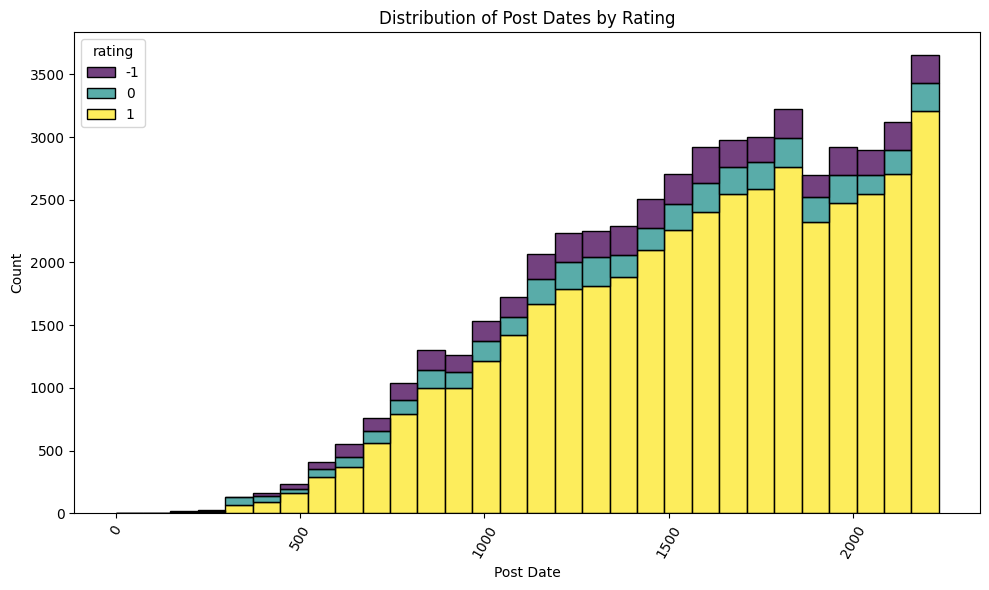

In [5]:
# Create a histogram of 'postDate' by 'rating'
plt.figure(figsize=(10, 6))
sns.histplot(data=sexDat, x='postDate', hue='rating', multiple='stack', palette='viridis', bins=30)
plt.title('Distribution of Post Dates by Rating')
plt.xlabel('Post Date')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=60)  

# Adjust the layout to make room for the rotated x-axis labels
plt.tight_layout()  

plt.show()

The plot above reveals that the number of satisfied buyers increases
through time. Now let's take a peek on the distribution of posts by riskiness of anal sex. Before I do this, the column `analSexWithC` will be transformed to `analSexWithC_mapped` wherein: (1) 1 -> `Risky`, -1 -> `Safe`, and 0 -> `NA`.

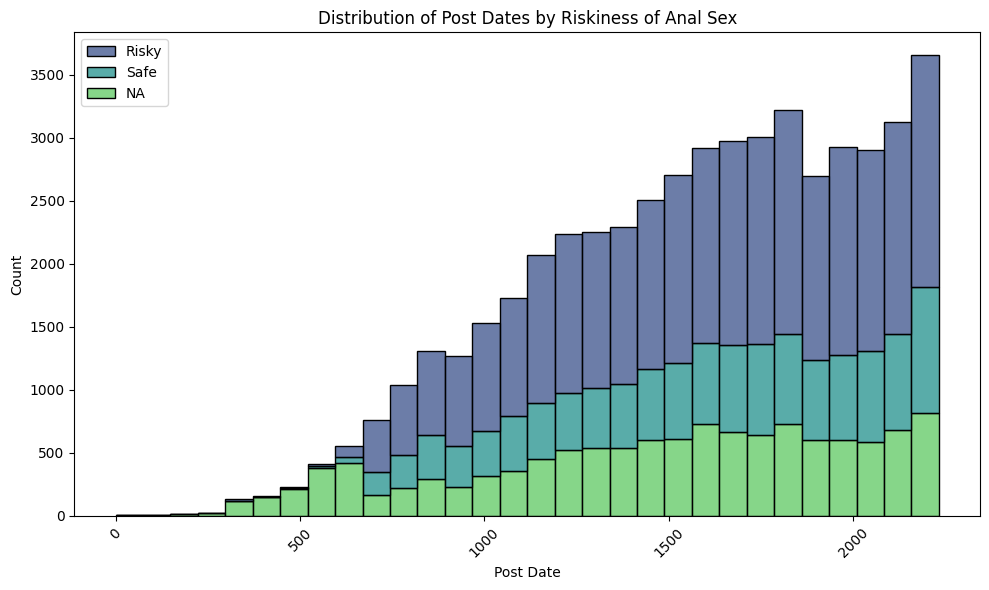

In [6]:
# Map the 'analSexWithC' values for the legend for better readability
sexDat['analSexWithC_mapped'] = sexDat['analSexWithC'].map({1: 'Risky', -1: 'Safe', 0: 'NA'})

# Create a histogram of 'postDate' by 'analSexWithC_mapped'
plt.figure(figsize=(10, 6))
ax = sns.histplot(data=sexDat, x='postDate', hue='analSexWithC_mapped', multiple='stack', palette='viridis', bins=30, hue_order=['Risky', 'Safe', 'NA'])

# Remove the legend title
# legend fix source: https://github.com/mwaskom/seaborn/issues/2669
ax.get_legend().set_title("")  


plt.title('Distribution of Post Dates by Riskiness of Anal Sex')
plt.xlabel('Post Date')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)  

# Adjust the layout to make room for the rotated x-axis labels
plt.tight_layout()  

plt.show()

The plot implies that the number of risky sexual encounters increases with time. Now note that there are three sex routes in the dataset: anal sex, oral sex, and mouth kissing. I introduce another column `numActs` that sums the number of sexual acts done per post: if all sexual routes were performed (regardless if it is risky or otherwise), then `numActs`=3.

In [7]:
# Create a new column 'numActs' that combines the elements of the last 3 columns as a list and then calculates the number of elements that are >0
sexDat['numActs'] = sexDat[['analSexWithC', 'oralSexWithC', 'mouthKiss']].apply(lambda x: sum(i > 0 for i in x), axis=1)

In [46]:
sexDat.head(1)

,fID,mID,postDate,rating,analSexWithC,oralSexWithC,mouthKiss,analSexWithC_mapped,numActs
0,0,1,0,0,0,0,0,NA,0


Now let's determine the distribution of posts with the number of acts performed `numActs`.

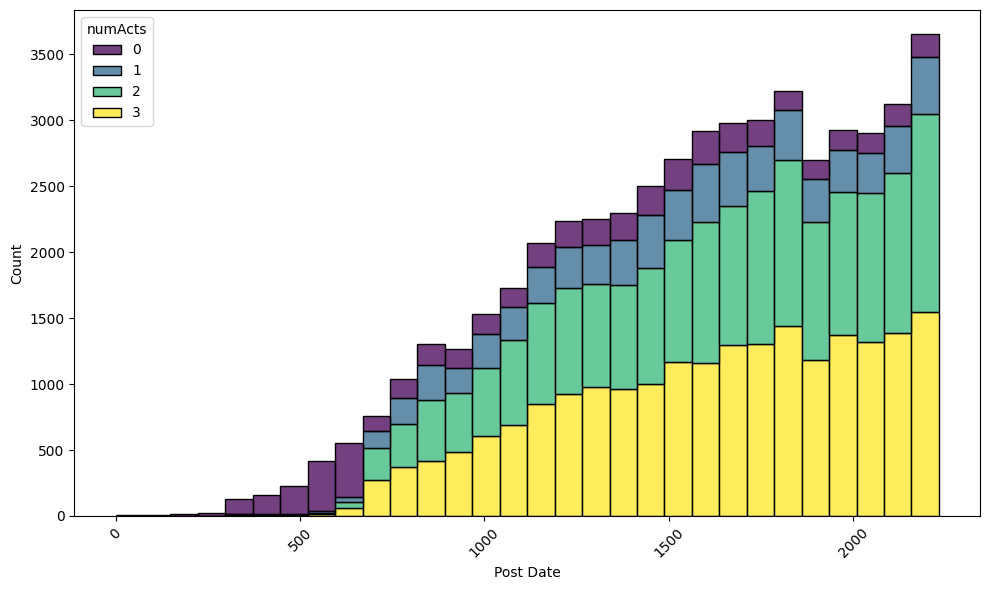

In [8]:
# Create a histogram of 'postDate' by 'numActs'
plt.figure(figsize=(10, 6))
sns.histplot(data=sexDat, x='postDate', hue='numActs', multiple='stack', palette='viridis', bins=30)
plt.xlabel('Post Date')
plt.ylabel('Count')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)  

# Adjust the layout to make room for the rotated x-axis labels
plt.tight_layout()  

plt.show()

The plot reveals that the number of posts that had sexual encounters with more than 1 act increases with time. 

This leads me to ask: how risky were the sexual encounters with 2-3 acts? Let's come up with a proportion histogram of `rating` and `numActs` with the riskiness of anal sex. Since posts with riskiness of `NA` bring no information, I removed it from the dataset and then gave it a new name: `sexDatNONA`.

In [9]:
# define dataframe sexDatNONA where analSexWithC==0 is removed
sexDatNONA = sexDat[sexDat.analSexWithC!=0]
sexDatNONA.head() 

,fID,mID,postDate,rating,analSexWithC,oralSexWithC,mouthKiss,analSexWithC_mapped,numActs
1,2,1,0,1,-1,1,-1,Safe,1
13,18,19,179,1,1,1,0,Risky,2
16,22,23,184,1,1,1,1,Risky,3
22,31,32,206,0,1,0,0,Risky,1
36,46,40,252,1,1,1,1,Risky,3


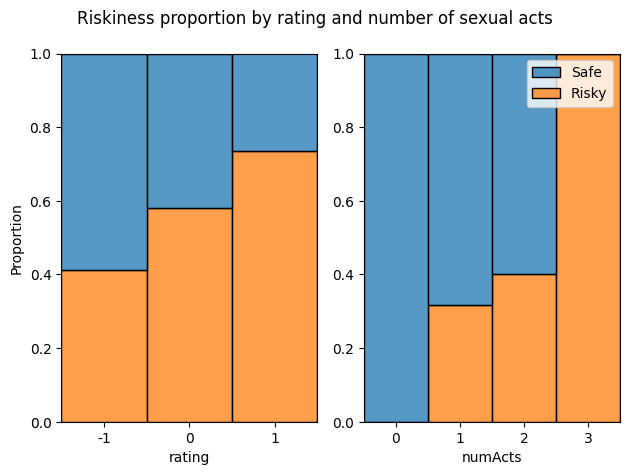

In [10]:
# Generate proportion histogram for 'rating' and 'numActs' with the degree of riskiness (of anal sex)
# Calculate the midpoints for xticks
num_bins0 = sexDatNONA['rating'].nunique()
bin_edges0 = np.linspace(sexDatNONA['rating'].min(), sexDatNONA['rating'].max(), num_bins0 + 1)
bin_midpoints0 = (bin_edges0[:-1] + bin_edges0[1:]) / 2

num_bins1 = sexDatNONA['numActs'].nunique()
bin_edges1 = np.linspace(sexDatNONA['numActs'].min(), sexDatNONA['numActs'].max(), num_bins1 + 1)
bin_midpoints1 = (bin_edges1[:-1] + bin_edges1[1:]) / 2


# Plot
fig, (ax0, ax1) = plt.subplots(1, 2)
sns.histplot(sexDatNONA, x="rating", hue="analSexWithC_mapped", multiple="fill",bins=num_bins0,ax=ax0, legend=False)
sns.histplot(sexDatNONA, x="numActs", hue="analSexWithC_mapped", multiple="fill",bins=num_bins1,ax=ax1)

ax0.set_xticks(bin_midpoints0)
ax1.set_xticks(bin_midpoints1)

ax0.set_xticklabels(np.sort(sexDatNONA['rating'].unique()))
ax1.set_xticklabels(np.sort(sexDatNONA['numActs'].unique()))

ax0.set_ylabel('Proportion')
ax1.set_ylabel('')

# Remove the legend title
ax1.get_legend().set_title("")  

fig.suptitle("Riskiness proportion by rating and number of sexual acts")

# Adjust the layout to make room for the rotated x-axis labels
plt.tight_layout()  

plt.show()

The proportion histograms show four things: <br>
1. Sexual encounters that had 3 sexual acts were ALL RISKY (in terms of anal sex)
2. Sexual encounters that NO sexual acts were ALL SAFE.
3. The degree of riskiness of anal sex increases with the number of sexual acts performed.
4. Positively and poorly rated sexual encounters tend to be on the risky and safe ends, respectively.

## Network Analysis
After analyzing the dataset, let us probe the network structure of the online forum-based sexual contacts between sex buyers and escorts (sellers).

Sellers and buyers are treated as **nodes**. An **edge** is formed if a buyer writes a post about a sexual encounter with a seller.

fID and mID collectively describe the relationships between sellers and buyers, respectively.

In [50]:
sexDat[['fID', 'mID']].head(2)

,fID,mID
0,0,1
1,2,1


In the sample data display above, buyer with `fID` 0 and seller with `mID` 1 had a sexual encounter and  are connected in the sexual network. 

Let's check the frequencies of (`fID`,`mID`) pairs.

In [11]:
pair_counts = sexDat.groupby(['fID','mID']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pair_counts

,fID,mID,counts
24986,8685,4570,41
12915,3935,13329,39
317,18,1106,36
22224,7632,1636,34
1406,98,1300,33
...,...,...,...
14022,4265,13788,1
14021,4265,13264,1
14020,4265,12945,1
14019,4265,12363,1


The total number of sexual contacts can be calculated through the `counts` column.

In [30]:
numSContacts = pair_counts['counts'].sum()
print(f'Total number of sexual contats is {numSContacts}.')

Total number of sexual contats is 50632.


The table display shows that the (`fID`,`mID`) pair (8685, 4570) had the highest numbers of connections (or sexual encounters) throughout the network.

## Quick refresher on networks
Let's have a small primer on networks. Most of the networks are *unipartite*, which means that nodes are associated to only one type [[3](https://ecology.dlilab.com/lectures/10_networks/notes)]. A common example is a social network, wherein nodes are individuals and links denote relationships/connections between them. Networks can also be *bipartite*, in which nodes can be assigned to two different types. In the first example, the network is unipartite since sex is not considered -- all of them are humans! To make that network bipartite, we assign sex to the nodes -- male or female. Now, edges in bipartite networks work this way: nodes are either assigned in type $A_{1}$ or $A_{2}$. Edges are formed between a node in $A_{1}$ and a node in $A_{2}$. [[4](https://appliednetsci.springeropen.com/articles/10.1007/s41109-023-00533-y)].



Networks can also be _directed_ or _undirected_. [[5](https://www.mathworks.com/help/matlab/math/directed-and-undirected-graphs.html)] Undirected networks have edges that don't have a direction, which signifies a two-way or bidirectional relationship between the nodes. Directed networks, from the name itself, have directions in its edges. These edges exhibit one-way relationships.

Lines of code below show some examples of such networks.


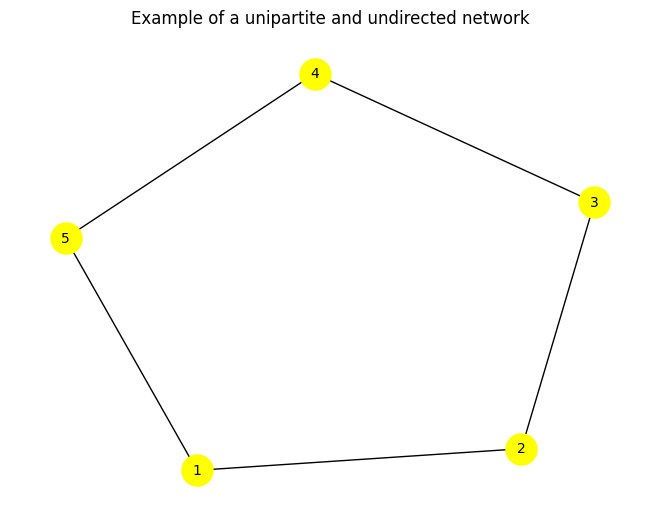

In [52]:
# Goal: Create a sample unipartite network of size 5
Gsamp_uni = nx.Graph()

# Add 5 nodes
Gsamp_uni.add_nodes_from([1, 2, 3, 4, 5])

# Add some edges between nodes
Gsamp_uni.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1)])

# Construct and display the network
nx.draw(Gsamp_uni, with_labels=True, node_color='yellow', edge_color='k', node_size=500, font_size=10)
plt.title("Example of a unipartite and undirected network")
plt.show()

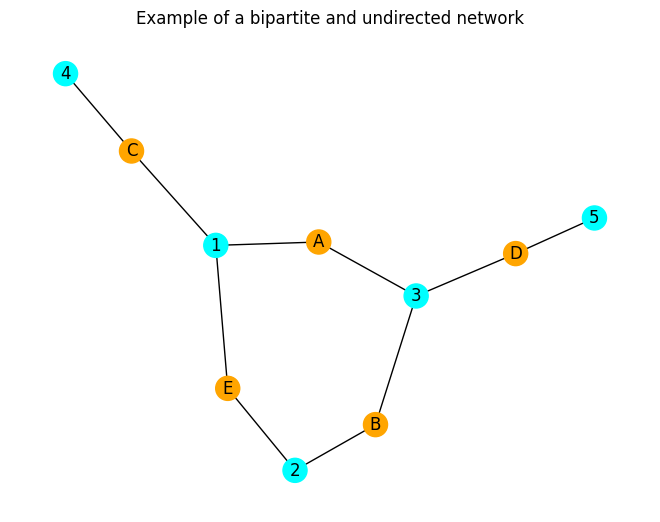

In [53]:
# Create a sample bipartite graph
Gsamp_bip = nx.Graph()

# Add nodes with the bipartite attribute
Gsamp_bip.add_nodes_from([1, 2, 3, 4, 5], bipartite=0)  # compartment 0
Gsamp_bip.add_nodes_from(['A', 'B', 'C', 'D', 'E'], bipartite=1)  # compartment 1

# Add edges between nodes of different sets
Gsamp_bip.add_edges_from([(1, 'A'), (3, 'B'), (4, 'C'), (5, 'D'), (2, 'E'),
                          (2, 'B'), (1, 'C'), (3, 'D'), (1, 'E'), (3, 'A')])

# Visualize the bipartite network
nx.draw(Gsamp_bip, with_labels=True, node_color=['cyan' if n in [1, 2, 3, 4, 5] else 'orange' for n in Gsamp_bip])
plt.title("Example of a bipartite and undirected network")
plt.show()

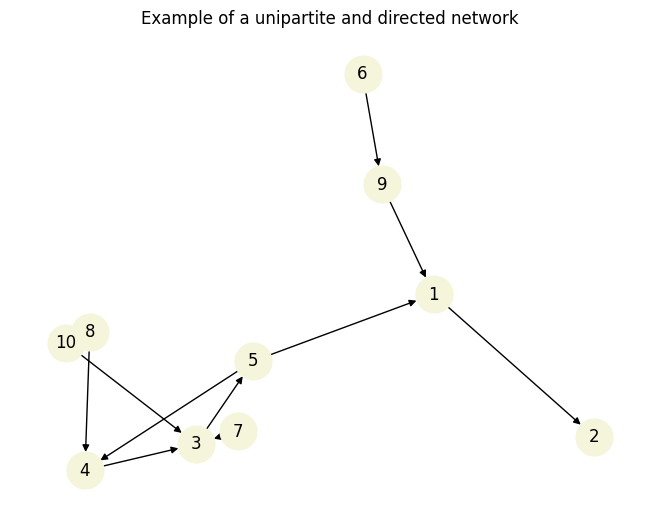

In [54]:
# Create a directed graph
Gsamp_dir = nx.DiGraph()

# Add 10 nodes. Assuming you want nodes numbered 1 through 10.
Gsamp_dir.add_nodes_from(range(1, 11))

# Add some edges to make it a directional network
edges = [(1, 2), (4, 3), (5, 4), (3, 5), (5, 1), (6, 9), (7, 3), (8, 4), (9, 1), (10, 3)]
Gsamp_dir.add_edges_from(edges)


nx.draw(Gsamp_dir, with_labels=True, node_color='beige', edge_color='black', node_size=700, arrows=True)
plt.title("Example of a unipartite and directed network")
plt.show()

Let's go back and now plot the network! 


From the networkX documentation [[6](https://networkx.org/documentation/stable/reference/algorithms/bipartite.html)], one of the ways to create a bipartite network is to utilize a node attribute, say bipartite, with values 0 or 1 to identify the sets each node is assigned to. 

Aside from the bipartite network setup, I also assigned a weight attribute to the edges. These weights denote the number of encounters between a (`fID`, `mID`) pair throughout the network. Thicker edges denote high occurrences of that pair in the sexual network.

In [13]:
# Initialize the graph
G = nx.Graph()


# Add nodes for females and males, specifying the bipartite attribute
# 0 for females, 1 for males
G.add_nodes_from(pair_counts['fID'].unique(), bipartite=0)
G.add_nodes_from(pair_counts['mID'].unique(), bipartite=1)

# Add edges between female and male nodes based on the pair_counts dataframe
# 'weight' attribute is also added to denote the number of encounters between a (mID, fID) pair throughout the network
for _, row in pair_counts.iterrows():
    G.add_edge(row['fID'], row['mID'], weight=row['counts'])

Before we plot the network, let's see. how many nodes and edges were there. Here are the ways to do it.
To get the **number of nodes**, use: <network_name>.`order()` or <network_name>.`number_of_nodes()`

In [56]:
# to get the number of nodes, use G.order() or G.number_of_nodes()
G.order() == G.number_of_nodes()

True

In [14]:
numNodes = G.order()
print(numNodes)

16730


Now this is also equal to the sum of the numbers of unique elements in `fID` and `mID` in the dataset `sexDat`.

In [58]:
numNodes == sexDat['fID'].nunique() + sexDat['mID'].nunique()

True

To get the **number of edges**, use <network_name>.`size()` or <network_name>.`number_of_edges()`

In [59]:
# to get the number of edges, use G.size() or G.number_of_edges()
G.size() == G.number_of_edges()

True

In [60]:
numEdges = G.size()
print(numEdges)

39044


Now this is also equal to the number of rows in the `pair_counts` dataframe.

In [79]:
numEdges == pair_counts.shape[0]

True

Wait...why is it that the total number of contacts is different from the number of edges? **50632 contacts** vs **39044 edges**? This is because some buyer-seller pairs **appreared more than once** in the sexual network, quantified through the `weight` edge attribute.

The number of edges is too big. Instead of plotting the network $G$, I intended to save it as a `.gexf` file and open it yourself on a powerful network visualization app **Gephi** [[8](https://gephi.org)].

In [80]:
nx.write_gexf(G, "sexNet.gexf")

I advise to check the entire sexual network yourself using Gephi and let me know what you think! 

For the network theory geeks out there, I laid out some key properties of the sexual network $G$: <br><br>
(1) average degree $\langle k \rangle = \frac{1}{N} \sum_{i=1}^{N}k_{i} = \frac{2E}{N}$ [[7](https://netsci.hongtaoh.com/degree-average-degree-and-degree-distribution-ch-2-3#), [8](https://global.oup.com/academic/product/networks-9780198805090?cc=ph&lang=en&)], where $N$ is the network size, $E$ is the total number of edges, and $k_{i}$ is node $i$'s degree (or the number of edges connecting $i$ to the other nodes). <br>

(2) average shortest path length $\ell = \frac{1}{N(N-1)}\sum_{i \neq j}{d(v_{i},v_{j})}$ [[9](https://math.stackexchange.com/questions/885196/average-path-length-cant-figure-out-the-meaning-of-large-frac1nn-1)] <br>

(3) average clustering coefficient $C = \frac{1}{N}\sum_{i}c_{i}$ where $c_{i} = \frac{2E_{i}}{N(N-1)}$ [[10](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.74.47)] <br>

<!-- to-do: add the following:
(4) betweenness centrality <br>
(5) diameter <br>
(6) degree assortativity <br>
(7) density <br>

 -->

In [26]:
# (1) average degree
avgDegree = 2*G.size() / G.order() # or sum(dict(G.degree()).values()) / G.order()

# (2) average shortest path length
try:
    avgSPL = nx.average_shortest_path_length(G, weight='weight')
except nx.NetworkXError as err:
    avgSPL = None
    print('Cannot compute average_shortest_path_length - {}'.format(err))
    

# (3) average clustering coefficient
avgClustering = nx.average_clustering(G)

print({'average degree': round(avgDegree,2), 'clustering coefficient': round(avgClustering,2)})

Cannot compute average_shortest_path_length - Graph is not connected.
{'average degree': 4.67, 'clustering coefficient': 0.0}


Instead of plotting the entire sexual network, we consider three network cases: <br>
1. **top 2** nodes in terms of degree as well as its neighbors and edges <br>
2. **bottom 50** nodes in terms of degree as well as its neighbors and edges <br>
3. first 50 nodes in the **bottom 10%** in terms of degree <br>

In [15]:
# let's retrieve the node list in each case

degrees = dict(G.degree())

# CASE 1: top 2 nodes in terms of degree
# note: degrees is a dictionary, and using sorted() on a dictionary returns
#       the keys that are sorted according to the per-key value
#       and are arranged in descending order (through reverse=True)
nodeListA = sorted(degrees, key=degrees.get, reverse=True)[:2]

# CASE 2: bottom 50 nodes in terms of degree
nodeListB = sorted(degrees, key=degrees.get, reverse=True)[-50:]


# CASE 3: first 50 nodes in the bottom 10% in terms of degree
# This case is a bit tricky, but to start, the threshold is computed
# for the bottom 10% in terms of degree. 
# After this, retrieve the nodes with degrees meeting the threshold.

# 3.1. Calculate the threshold for the bottom 10% of degrees
## TIP:
## bottom 10% = np.percentile(list(degrees.values(), 10)
## top 10% = np.percentile(list(degrees.values(), 90)
num=50; pct=10
pctThresh = np.percentile(list(degrees.values()), pct)

# 3.2. Filter nodes with degrees that meet the threshold
nodeListC = [node for node, degree in degrees.items() if degree <= pctThresh]

# 3.3. If there are more than <num> nodes in the bottom/top x%, select only the first <num>
if len(nodeListC) > num:
    nodeListC = nodeListC[:num]


Let's now check the compositions of the node lists per case.

In [63]:
print(nodeListA, '\n', len(nodeListA))

[18, 4200] 
 2


In [64]:
print(nodeListB, '\n', len(nodeListB))

[4406, 4459, 4556, 5999, 4264, 4968, 4918, 5169, 4266, 14426, 16106, 4209, 15108, 14524, 13555, 12966, 4809, 5439, 4229, 4231, 4233, 5454, 4226, 9615, 9161, 6687, 8508, 5613, 16187, 15004, 14194, 13767, 8848, 4401, 4557, 4698, 5244, 7772, 4316, 4375, 8058, 8205, 8929, 11751, 6594, 6572, 5896, 4273, 14850, 16729] 
 50


In [65]:
print(nodeListC, '\n', len(nodeListC))

[7505, 10182, 2976, 8865, 14935, 5983, 11048, 12373, 12580, 9113, 16235, 3700, 1670, 13826, 13728, 11089, 15958, 6410, 8291, 5545, 4820, 4910, 6337, 2447, 2419, 6461, 11989, 6499, 11865, 11819, 11903, 13466, 11413, 11626, 2486, 7037, 12503, 7244, 12738, 6960, 12912, 12680, 12669, 1228, 6659, 12120, 6602, 12255, 1934, 8635] 
 50


Now that the node lists have been determined, it's time to generate the network per case and then plot! I've prepared functions to (1) extract the selected network from the source network (in our case, it's the network `G`); and (2) plot those networks.

In [16]:
def extractSelectedNetwork(network, nodeList):
    """
    Plots a specific subgraph of the network
    
    Inputs:
    --------
    network: network
    nodeList: selected nodes from the network
    
    
    Returns:
    --------
    GSample: selected network
    """
    GSample = nx.Graph()
    
    # Add the top node/s with their attributes to the new graph
    for node in nodeList:
        GSample.add_node(node, **G.nodes[node])

        # For each of the top nodes, add their neighbors and the edges between
        for neighbor in network.neighbors(node):
            GSample.add_node(neighbor, **G.nodes[neighbor])
            GSample.add_edge(node, neighbor, **G[node][neighbor])

    # Ensure all attributes are copied for the edges
    for u, v, data in GSample.edges(data=True):
        GSample[u][v].update(data)  
        
    return GSample

In [28]:
def drawNet(network, bipart=True, withWeight=True):
    """
    Plots the network. This covers bipartite networks and cases
    where edge weights are available and unavailable.
    
    
    Inputs:
    --------
    network: network
    
    
    Optional Inputs:
    ---------------------
    
    bipart (default=True): is the network bipartite?
                         : limitation: this only covers bipartite networks
                         
    withWeight (default=True): does the network have edge weights?
    
    """
    plt.clf()
    if withWeight:
        edgeWeights = nx.get_edge_attributes(network, 'weight')
        
    if bipart:
        # Draw the network
        posSample = nx.spring_layout(network, seed=1001)  # positions for all nodes, fixed seed for reproducibility

        nodeList0 = [n for n, d in network.nodes(data=True) if d.get('bipartite') == 0]
        nodeList1 = [n for n, d in network.nodes(data=True) if d.get('bipartite') == 1]


        # nodes
        nx.draw_networkx_nodes(network, posSample, nodelist=nodeList0, node_color='red', node_size=5)
        nx.draw_networkx_nodes(network, posSample, nodelist=nodeList1, node_color='blue', node_size=5)

        # edges
        if withWeight==False:
            nx.draw_networkx_edges(network, posSample, width=1.0, alpha=0.5)
        if withWeight==True:
            # [OPTIONAL] Normalize weights
            multiplier = 10  # tune the multiplier whenever necessary
            weights = [edgeWeights[edge] for edge in network.edges()]
            maxWeight = max(weights)
            normalizedWeights = [w / maxWeight * multiplier for w in weights] 

            nx.draw_networkx_edges(network, posSample, width=normalizedWeights, alpha=0.5)
            
        
        plt.axis('off')   

        # legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label='seller',
                                  markerfacecolor='red', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label='buyer',
                                  markerfacecolor='blue', markersize=5)]
        plt.legend(handles=legend_elements)

It's time to plot the networks!

In [18]:
GA = extractSelectedNetwork(G, nodeListA)
GB = extractSelectedNetwork(G, nodeListB)
GC = extractSelectedNetwork(G, nodeListC)

CASE 1:  **top 2** nodes in terms of degree as well as its neighbors and edges

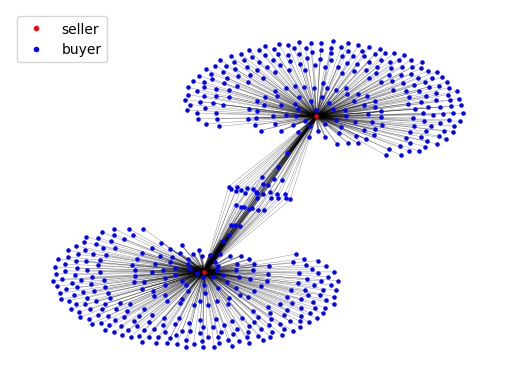

In [27]:
drawNet(GA)

CASE 2: **bottom 50** nodes in terms of degree as well as its neighbors and edges

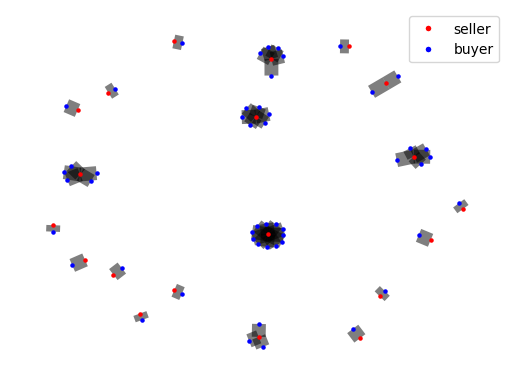

In [20]:
drawNet(GB)

CASE 3: first 50 nodes in the **bottom 10%** in terms of degree

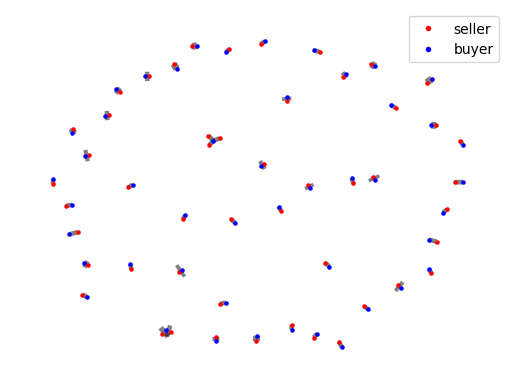

In [21]:
drawNet(GC)

To check the node attributes in the network (huge thanks to Stack Overflow! yes, in 2024, still useful!):

In [23]:
## Get the list of node attributes in a network
def check_nodeEdge_attributes(network, how='both'):
    """
    This function check node and edge attributes in a network.
    
    Inputs:
    --------
    
    network: network
    how ('node', 'edge', 'both'; default='both'): checks whether to get node
                                                  or edge attribute or both
                                                  
    Output:
    ---------
    if how=='both': nodeAttrib, edgeAttrib
    if how=='node': nodeAttrib
    if how=='edge': edgeAttrib    
    
    
    nodeAttrib: set
              : node attributes
    edgeAttrib: set
              : edge attributes    
    """
    if how=='both':
        nodeAttrib = set([k for n in network.nodes for k in network.nodes[n].keys()])
        edgeAttrib = set([k for n in network.edges for k in network.edges[n].keys()])
        return nodeAttrib,edgeAttrib
    if how=='node':
        nodeAttrib = set([k for n in network.nodes for k in network.nodes[n].keys()])
        return nodeAttrib
    if how=='edge':
        edgeAttrib = set([k for n in network.edges for k in network.edges[n].keys()])
        return edgeAttrib
    

# let's check the node and edge attributes of network GA
nodeAttribGA, edgeAttribGA =  check_nodeEdge_attributes(GA)
print(nodeAttribGA, edgeAttribGA)

{'bipartite'} {'weight'}


Now that networks have been created and some network properties have been explored, I will discuss another key network property: the **degree distribution** $p(k)$. Creating it is simple: it's just a histogram of the degree of the network.

I generate $p(k)$ of the sexual network $G$.

Text(1.15, 2.1905917110943514, '$\\alpha = 1.50$')

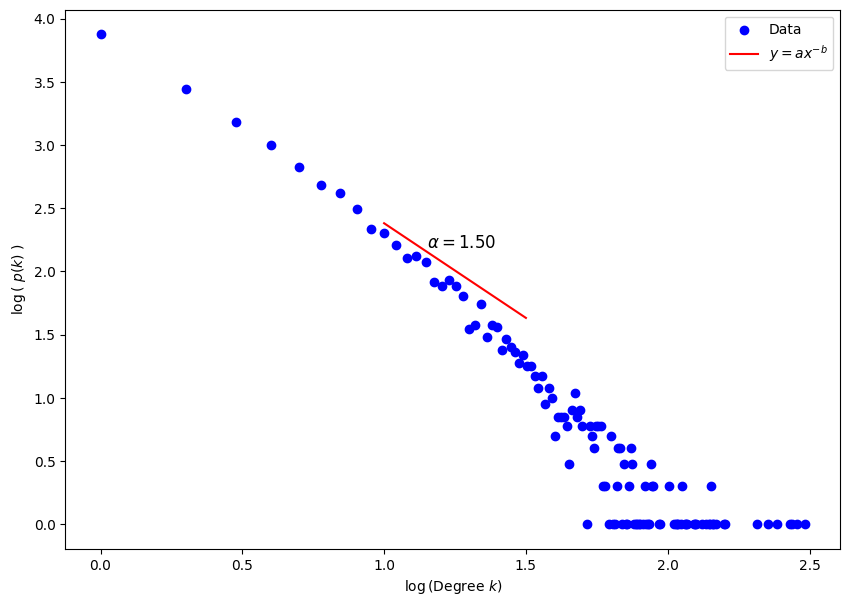

In [25]:
# To generate the degree distribution p(k), first 
# get the degree counts (assuming k > 0)
degreeList = [d for n, d in G.degree()]

# Determine the unique degrees and their counts
uniqueDegrees = np.array( sorted(set(degreeList)) )
counts = np.array( [degreeList.count(x) for x in uniqueDegrees] )

# The plan is to create a log-log plot for the degree distribution
# Matplotlib can be used to transform the axes (via plt.loglog),
# but another way to do it is to transform the degrees and counts
# in their logarithms then plot as usual.
logDegrees = np.log10(uniqueDegrees)
logCounts = np.log10(counts)

# Plot
plt.figure(figsize=(10, 7))
plt.scatter(logDegrees, logCounts, label='Data', color='b')

# The next part is to generate a best-fit line for the 
#   degree distribution using a function y = a*(-x**b)
# I made an initial scoping and realized that
#   power law function is the best representation of
#   p(k) of the sexual network
def powerLaw(x, a, b):
    return a * np.power(x, -1*b)

# Fit the power law function to the data
params, covariance = curve_fit(powerLaw, uniqueDegrees, counts)

# Plot the best-fit line along a specific range
x = np.linspace(1, 1.5, 100)
plt.plot(x, np.log10(powerLaw(10**x, *params)), 'r-', label='$y = ax^{-b}$')

plt.xlabel('$\log$(Degree $k$)')
plt.ylabel('$\log$( $p(k)$ )')
plt.legend()

# Add text for the exponent of the power-law distribution
plt.text(1.15, 0.95*np.log10(powerLaw(10**1.05, *params)), f"$\\alpha = {params[1]:.2f}$", fontsize=12)

The plot reveals that the degree distribution of the sexual network follows a **power law** with exponent $\alpha = 1.50$.

I performed exploratory data analysis of the collection of sexual contacts based on an online escort community and then probed the resulting sexual network. There are several routes to take on after this, such as mapping the network over a topographical unit (in this case, Brazil 🇧🇷) with the assumption that each buyer and seller are rnadomly assigned to a pair of (latitude, longitude) coordinates. Another route to take is to perform an infection model over the sexual network. This, I believe, is a good introduction to those who are interested in the realms of epidemics and networks. What if we do the same thing at my motherland -- the Philippines 🇵🇭? If only there are no bureaucracies especially in terms of data requests...


Let me know your thoughts on this notebook by reaching out to me via mail 📩: jprmaulion[at]gmail[dot]com. 